# Results Evaluation

In [1]:
%run ../scripts/load_df_for_analysis.py

In [2]:
%run ../scripts/data_visualisations.py

In [3]:
%run ../scripts/df_calculations.py

## Overall model results

### Comparison of best GPT and best Llama Model (from tested models on this data): <br>GPT 4.1 vs. Llama 3.1:70b

In [4]:
chunking = "1024_20"
only_text = True
model = "gpt-4.1-2025-04-14"
df_gpt = load_df_for_analysis(chunking, only_text, model)
results_gpt = eval_predictions(df_gpt, include_relabelled_partially=True)
results_gpt_no_partially = eval_predictions(df_gpt, include_relabelled_partially=False)

In [5]:
chunking = "256_20"
only_text = True
model = "llama3.1.70b"
df_llama = load_df_for_analysis(chunking, only_text, model)
results_llama = eval_predictions(df_llama, include_relabelled_partially=True)
results_llama_no_partially = eval_predictions(df_llama, include_relabelled_partially=False)

In [6]:
results_llama_no_partially

{'G (Total)': 233,
 'P (Substantiated)': 126,
 'N (Unsubstantiated)': 107,
 'TP': 95,
 'FP': 8,
 'TN': 99,
 'FN': 31,
 'accuracy': 0.833,
 'precision': 0.922,
 'recall': 0.754,
 'specificity': 0.925,
 'f1_score': 0.83,
 'invalid_labels': {'Unsubstantiated': [], 'Substantiated': []}}

In [7]:
model_results = {
    "GPT-4.1": results_gpt,
    "Llama 3.1:70b": results_llama,
}

model_results_no_partially = {
    "GPT-4.1": results_gpt_no_partially,
    "Llama 3.1:70b": results_llama_no_partially
}

display_model_results_table(model_results)
display_model_results_table(model_results_no_partially)

,Accuracy,Precision,Recall,Specificity,F1_score
Model,,,,,
GPT-4.1,0.858,0.844,0.902,0.809,0.872
Llama 3.1:70b,0.822,0.893,0.758,0.896,0.820


,Accuracy,Precision,Recall,Specificity,F1_score
Model,,,,,
GPT-4.1,0.876,0.865,0.913,0.832,0.888
Llama 3.1:70b,0.833,0.922,0.754,0.925,0.830


In [8]:
preds_results = {
    "GPT-4.1": get_preds_results(results_gpt),
    "Llama 3.1:70b": get_preds_results(results_llama)
}

preds_results_no_partially = {
    "GPT-4.1": get_preds_results(results_gpt_no_partially),
    "Llama 3.1:70b": get_preds_results(results_llama_no_partially)
}

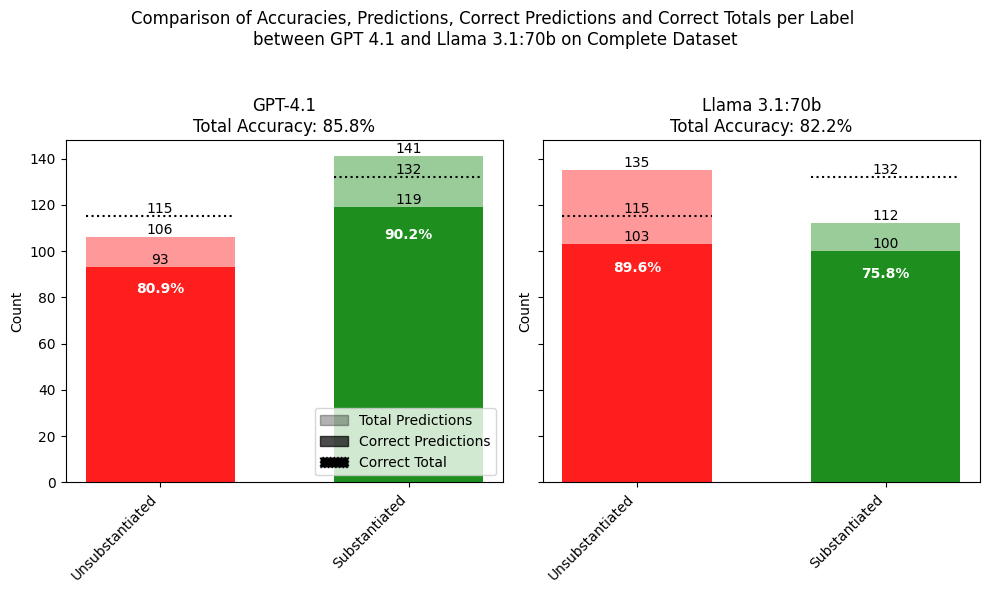

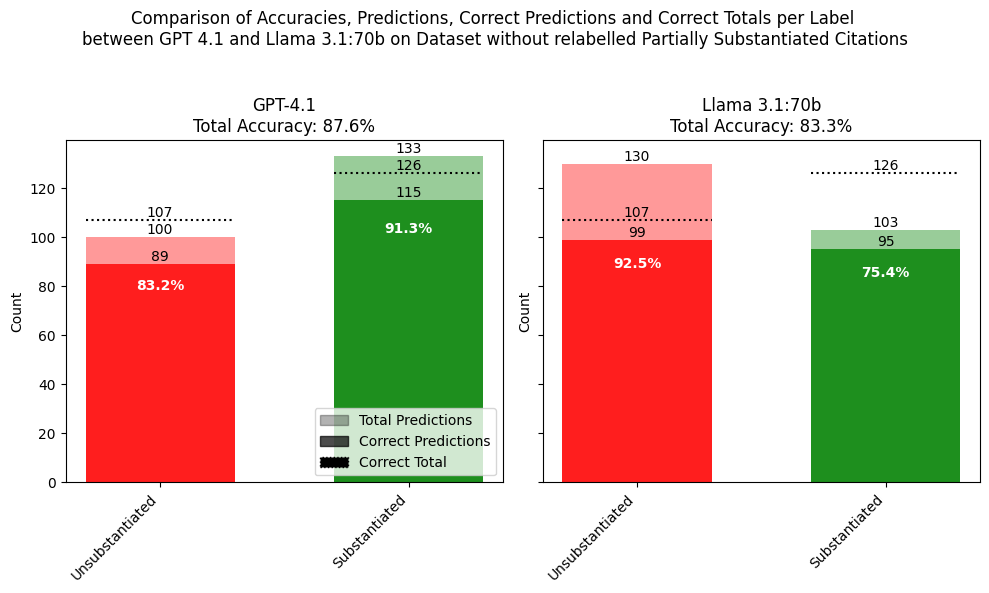

In [9]:
title = "Comparison of Accuracies, Predictions, Correct Predictions and Correct Totals per Label \nbetween GPT 4.1 and Llama 3.1:70b on Complete Dataset"
show_preds_vs_correct_preds_vs_total(list(preds_results.values()), list(preds_results.keys()), title=title, labels=['Unsubstantiated', 'Substantiated'], smaller_figures=True)

title = "Comparison of Accuracies, Predictions, Correct Predictions and Correct Totals per Label \nbetween GPT 4.1 and Llama 3.1:70b on Dataset without relabelled Partially Substantiated Citations"
show_preds_vs_correct_preds_vs_total(list(preds_results_no_partially.values()), list(preds_results.keys()), title=title, labels=['Unsubstantiated', 'Substantiated'], smaller_figures=True)

## Comparison: Evaluation per Annotation Attribute

In [10]:
def attribute_predictions_per_model(model_dfs, attribute, relabelled_partially=False, group_numbers_from=False):
    results = {}
    for model_name, df in model_dfs.items():
        results[model_name] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=True, group_numbers_from=group_numbers_from)
        if relabelled_partially:
            results[model_name + " (exclude relabelled partially)"] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=False, group_numbers_from=group_numbers_from)
    return results

In [11]:
def significance_per_attribute_per_model(model_dfs, attribute, group_numbers_from=False):
    for model_name, df in model_dfs.items():
        results = {}
        attribute_groups = get_attribute_value_groups(df, attribute, group_numbers_from)
        for group_name, attribute_values_list in attribute_groups:
            results[group_name] = calc_significance_of_accuracy_difference(
                eval_attribute_subset_vs_rest(df, attribute, attribute_values_list)
            )
        print(f"Significance results for {model_name} on attribute '{attribute}':")
        display_significance_test_results(results)

In [12]:
model_dfs = {
    "GPT-4.1": df_gpt,
    "Llama 3.1:70b": df_llama
}

### Reference Only

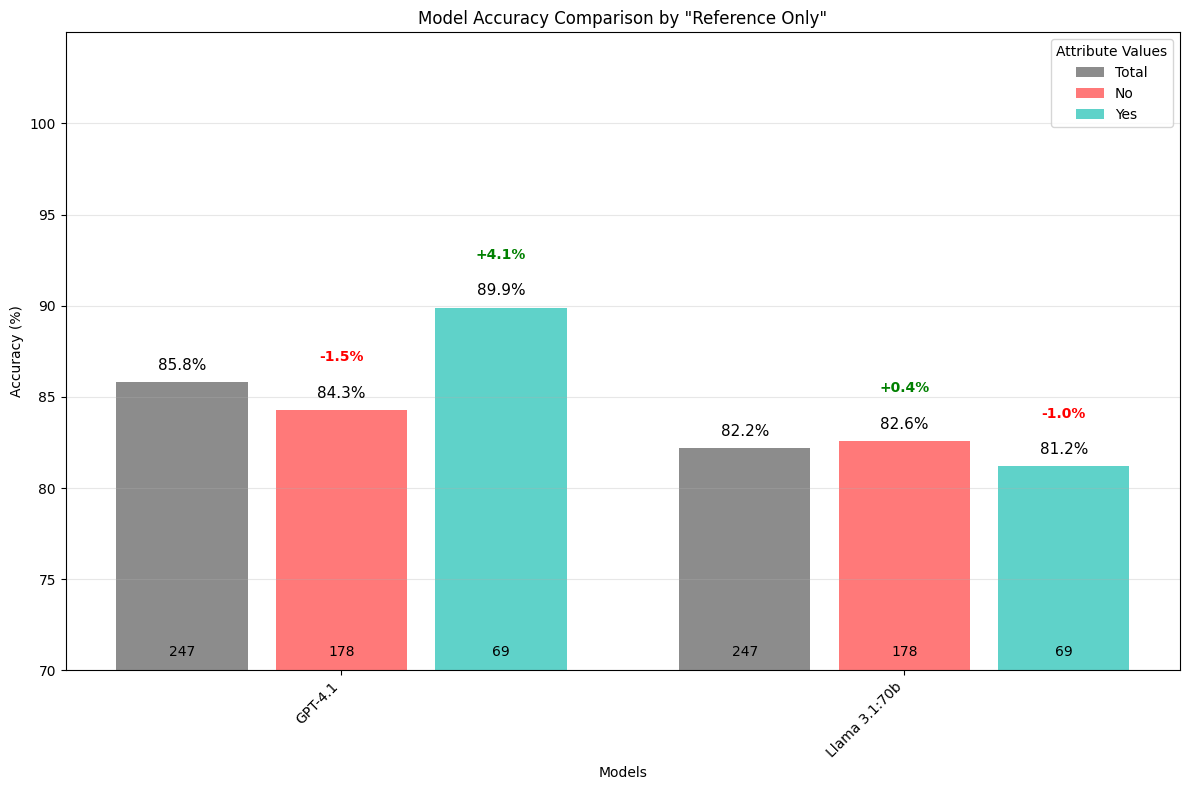

In [13]:
attribute = "Reference Only"
results = attribute_predictions_per_model(model_dfs, attribute)
# display_attribute_results_table(results, attribute, use_pandas=True)
# display_attribute_differences_to_total_table(results, attribute, use_pandas=True)
show_accuracy_by_attribute_values(results, attribute)

In [14]:
significance_per_attribute_per_model(model_dfs, attribute)

Significance results for GPT-4.1 on attribute 'Reference Only':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
Yes,1.1294,0.2587,1.6533,0.3129
No,-1.1294,0.2587,0.6048,0.3129


Significance results for Llama 3.1:70b on attribute 'Reference Only':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
Yes,-0.2626,0.7929,0.9084,0.8533
No,0.2626,0.7929,1.1008,0.8533


### Claim Contains Number or Formula

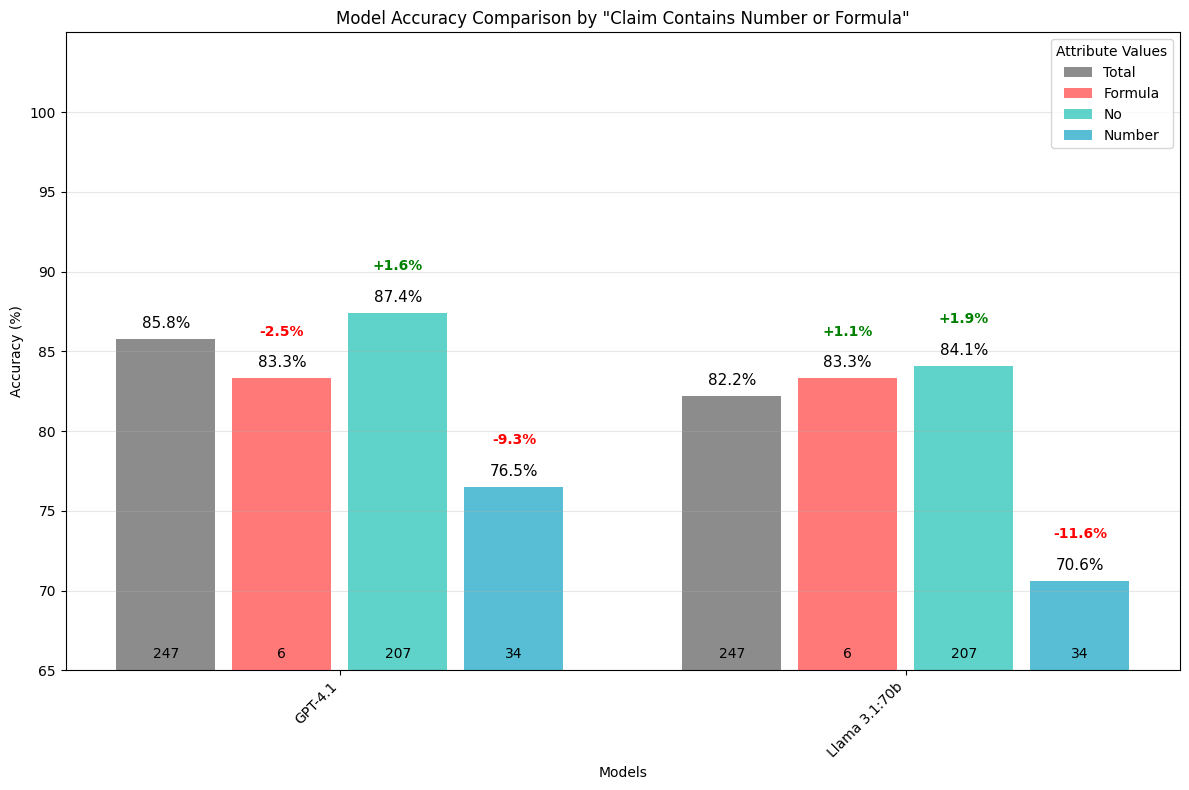

In [15]:
attribute = "Claim Contains Number or Formula"
results = attribute_predictions_per_model(model_dfs, attribute)
# display_attribute_results_table(results, attribute, use_pandas=True)
# display_attribute_differences_to_total_table(results, attribute, use_pandas=True)
show_accuracy_by_attribute_values(results, attribute, 65)

In [16]:
significance_per_attribute_per_model(model_dfs, attribute)

Significance results for GPT-4.1 on attribute 'Claim Contains Number or Formula':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
No,1.6502,0.0989,2.0211,0.1337
Number,-1.6852,0.0920,0.4718,0.1107
Formula,-0.1775,0.8591,0.8213,1.0000


Significance results for Llama 3.1:70b on attribute 'Claim Contains Number or Formula':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
No,1.7489,0.0803,2.0000,0.1114
Number,-1.9033,0.0570,0.4559,0.0874
Formula,0.0743,0.9407,1.0859,1.0000


### Amount Citations in Sentence

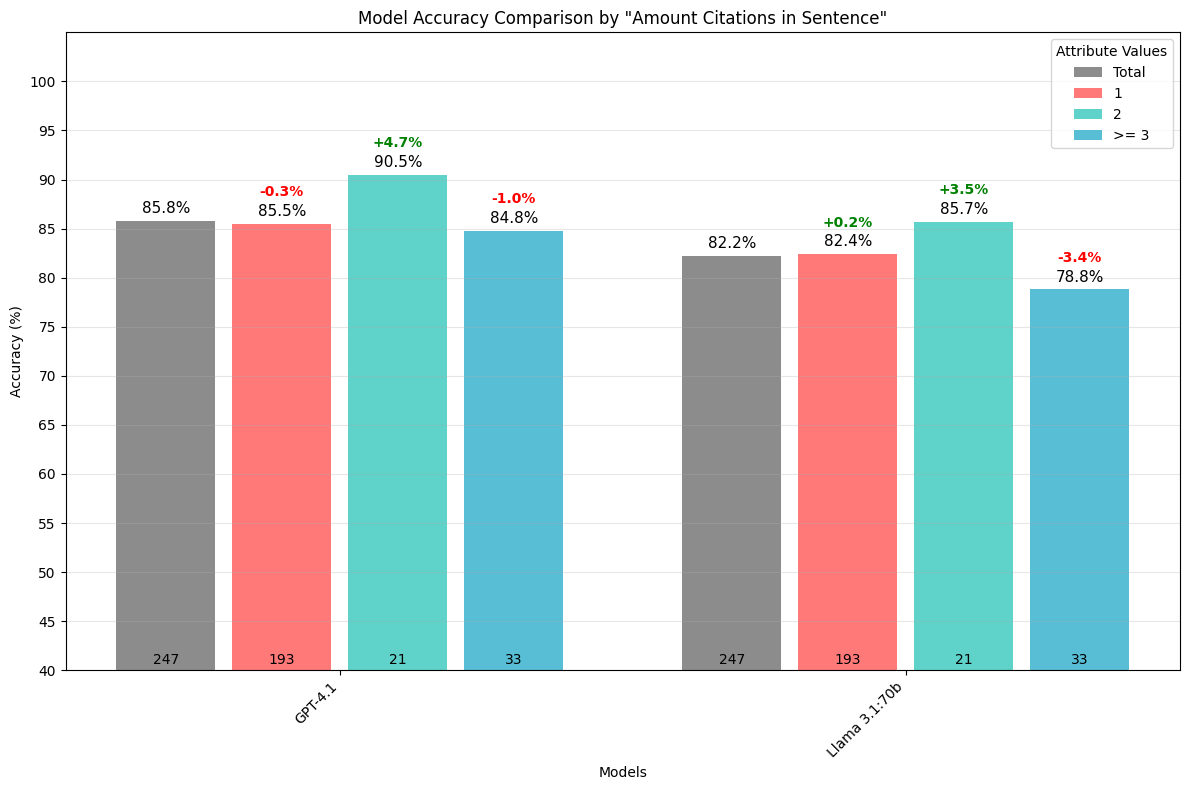

In [17]:
attribute = "Amount Citations in Sentence"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=3)
show_accuracy_by_attribute_values(results, attribute, 40)

In [18]:
significance_per_attribute_per_model(model_dfs, attribute, group_numbers_from=3)

Significance results for GPT-4.1 on attribute 'Amount Citations in Sentence':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
1,-0.2877,0.7735,0.8777,1.0000
2,0.6383,0.5233,1.6244,0.7472
>= 3,-0.1737,0.8621,0.9130,0.7929


Significance results for Llama 3.1:70b on attribute 'Amount Citations in Sentence':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
1,0.1531,0.8783,1.0628,0.8430
2,0.4417,0.6587,1.3297,1.0000
>= 3,-0.5481,0.5836,0.7764,0.6253


### Amount References for Claim

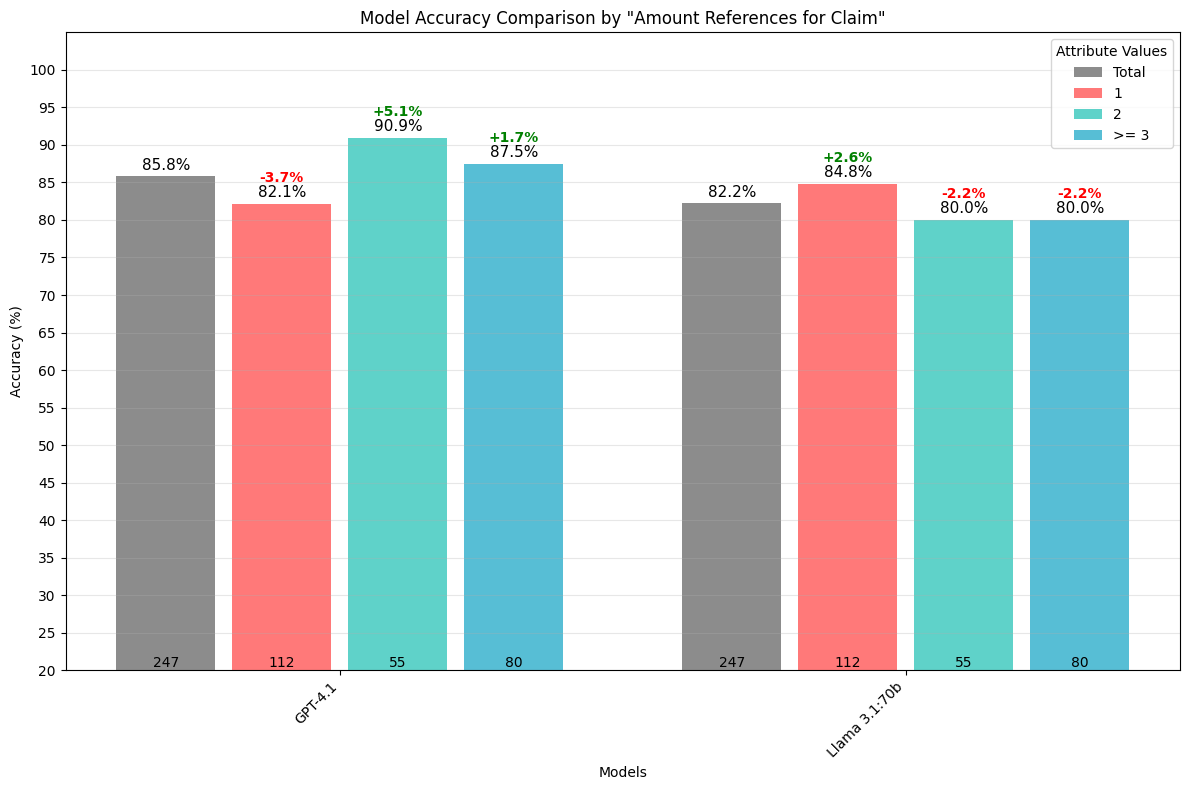

In [19]:
attribute = "Amount References for Claim"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=3)
show_accuracy_by_attribute_values(results, attribute, 20)

In [20]:
significance_per_attribute_per_model(model_dfs, attribute, group_numbers_from=3)

Significance results for GPT-4.1 on attribute 'Amount References for Claim':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
1,-1.5135,0.1302,0.5750,0.1453
2,1.2251,0.2205,1.8519,0.2763
>= 3,0.5209,0.6024,1.2324,0.6987


Significance results for Llama 3.1:70b on attribute 'Amount References for Claim':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
1,0.9859,0.3242,1.3971,0.4040
2,-0.4806,0.6308,0.8302,0.6897
>= 3,-0.6215,0.5343,0.8058,0.5947


### Claim Sentence Structure

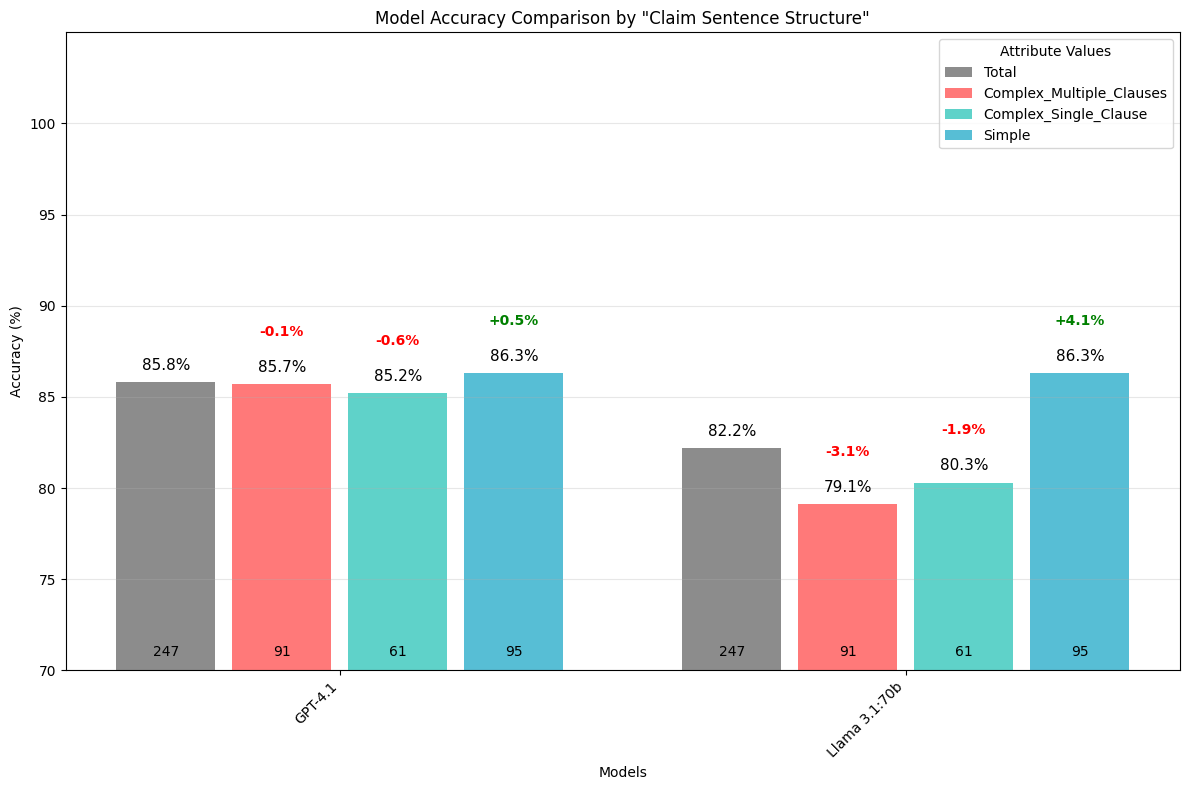

In [21]:
attribute = "Claim Sentence Structure"
results = attribute_predictions_per_model(model_dfs, attribute)
# display_attribute_results_table(results, attribute, use_pandas=True)
# display_attribute_differences_to_total_table(results, attribute, use_pandas=True)
show_accuracy_by_attribute_values(results, attribute)

In [22]:
significance_per_attribute_per_model(model_dfs, attribute)

Significance results for GPT-4.1 on attribute 'Claim Sentence Structure':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
Simple,0.1731,0.8626,1.0675,1.0000
Complex_Multiple_Clauses,-0.0398,0.9682,0.9851,1.0000
Complex_Single_Clause,-0.1507,0.8802,0.9389,0.8356


Significance results for Llama 3.1:70b on attribute 'Claim Sentence Structure':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
Simple,1.3410,0.1799,1.6160,0.2316
Complex_Multiple_Clauses,-0.9616,0.3362,0.7232,0.3894
Complex_Single_Clause,-0.4371,0.6620,0.8485,0.7008


### Amount Claims to Substantiate

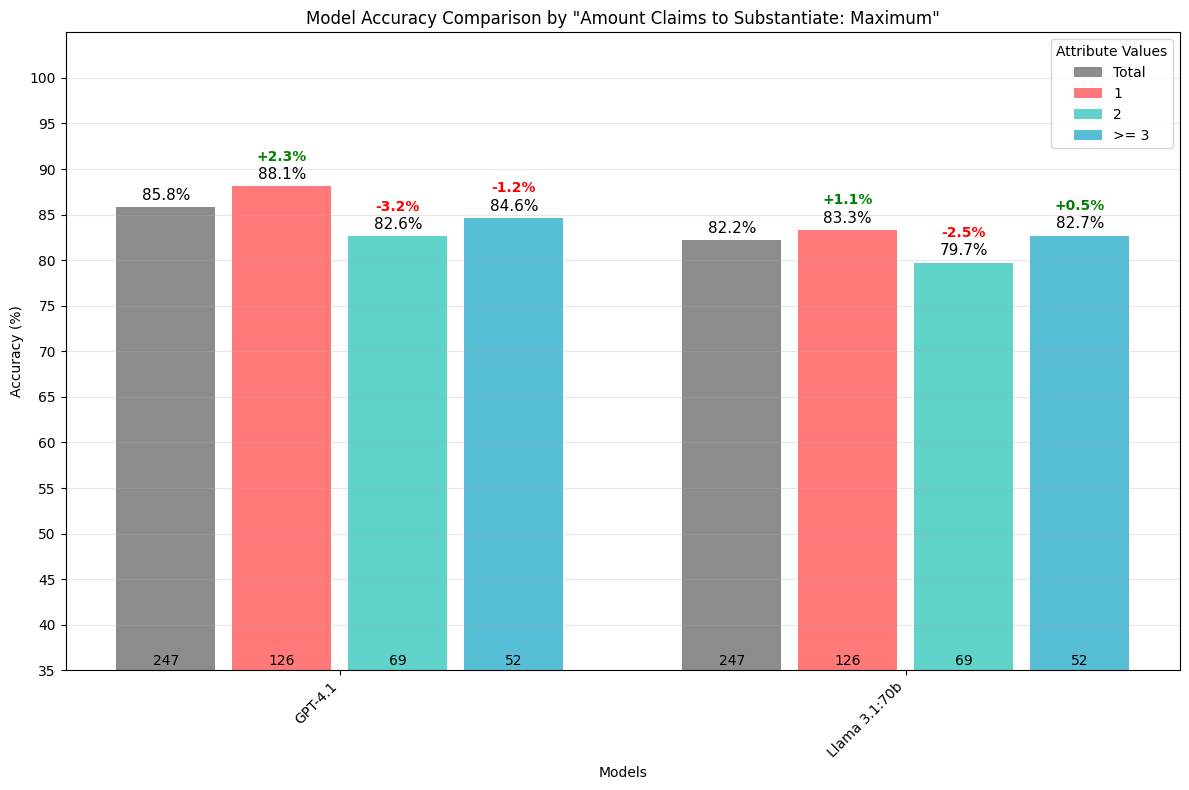

In [23]:
attribute = "Amount Claims to Substantiate: Maximum"
results = attribute_predictions_per_model(model_dfs, attribute, group_numbers_from=3)
show_accuracy_by_attribute_values(results, attribute, 35)

In [24]:
significance_per_attribute_per_model(model_dfs, attribute, group_numbers_from=3)

Significance results for GPT-4.1 on attribute 'Amount Claims to Substantiate: Maximum':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
1,1.0417,0.2975,1.4653,0.3623
2,-0.9038,0.3661,0.7048,0.4166
>= 3,-0.2827,0.7774,0.8839,0.8233


Significance results for Llama 3.1:70b on attribute 'Amount Claims to Substantiate: Maximum':


,Z-statistic,Z-test P-value,Odds Ratio,Fisher P-value
Attribute Value,,,,
1,0.4808,0.6307,1.1735,0.7397
2,-0.6332,0.5266,0.7963,0.5790
>= 3,0.1073,0.9145,1.0451,1.0000


The accuracy is slightly higher when there is only one claim in the sentence related to this citation, and slightly lower when there 2-4 claims (Llama 3.1). For more than 4 claims there are only less than 10 examples in the dataset, so the results are not really reliable. For GPT 4.1 the accuracy increases for a maximum of 4 claims for some reason?